In [25]:
using Convex
using PyPlot
using ECOS
set_default_solver(ECOSSolver(verbose=0))

INFO: Precompiling module ECOS.


ECOS.ECOSSolver(Any[(:verbose,0)])

In [135]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# ols is invariant

In [95]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [106]:
w = X\y
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = Xscale\yscale
@show Xscale*wscale / 5;

X * w = [7.4577,1.19841,-1.58183,2.13214,1.60703,1.21061,-1.61406,-1.2877,-5.00927,5.54936,-4.66583,1.40898,0.245428,-7.90381,3.97464,5.75913,-2.1955,-3.36963,-1.07186,-2.21103]
(Xscale * wscale) / 5 = [7.4577,1.19841,-1.58183,2.13214,1.60703,1.21061,-1.61406,-1.2877,-5.00927,5.54936,-4.66583,1.40898,0.245428,-7.90381,3.97464,5.75913,-2.1955,-3.36963,-1.07186,-2.21103]


# ridge regression is not scaling invariant

In [36]:
size(X'*X + eye(d))

(10,10)

In [107]:
w = (X'*X + eye(d)) \ (X'*y)
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = (Xscale'*Xscale + eye(d)) \ (Xscale'*yscale)
@show Xscale * wscale / 5;

X * w = [6.99974,1.13194,-1.56649,2.02894,1.54013,1.21125,-1.38596,-1.21458,-4.694,5.22009,-4.64034,1.34993,0.288636,-7.655,4.00599,5.64273,-2.21651,-3.10263,-0.9438,-2.18359]
(Xscale * wscale) / 5 = [7.40192,1.18918,-1.58089,2.12017,1.60057,1.2106,-1.58611,-1.2788,-4.97142,5.51089,-4.6649,1.4018,0.250202,-7.87452,3.97902,5.74681,-2.2003,-3.33715,-1.05829,-2.20682]


In [108]:
# standardize
function standardize(X,y)
    X_standard = X .- mean(X,1)
    X_standard = X_standard * diagm(1./vec(std(X,1)))
    
    y_standard = y - mean(y)
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

Xs, ys = standardize(X,y)
w = (Xs'*Xs + eye(d)) \ (Xs'*ys)
@show Xs*w

yscale = 5*y + 3000
Xscale = 3*X + 200

Xss, yss = standardize(Xscale,yscale)
wscale = (Xss'*Xss + eye(d)) \ (Xss'*yss)
@show Xss*wscale;

Xs * w = [1.81117,0.290291,-0.406826,0.528855,0.394133,0.305701,-0.366052,-0.297211,-1.19807,1.34787,-1.18189,0.356081,0.0653706,-1.9578,1.02568,1.43846,-0.57194,-0.791785,-0.243078,-0.548956]
Xss * wscale = [1.81117,0.290291,-0.406826,0.528855,0.394133,0.305701,-0.366052,-0.297211,-1.19807,1.34787,-1.18189,0.356081,0.0653706,-1.9578,1.02568,1.43846,-0.57194,-0.791785,-0.243078,-0.548956]


# let's compare different kinds of regularized regression

In [63]:
function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

ridge_regression (generic function with 1 method)

In [64]:
function lasso(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

lasso (generic function with 1 method)

In [20]:
function nnls(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y), w>=0)
    solve!(p)
    return w.value
end

nnls (generic function with 1 method)

In [113]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

In [123]:
# find best model for each type of data
w = w_pos

X,y = generate_data(30, w)
w_ridge = ridge_regression(X,y)
w_lasso = lasso(X,y; λ=1)
w_nonneg = nnls(X,y);

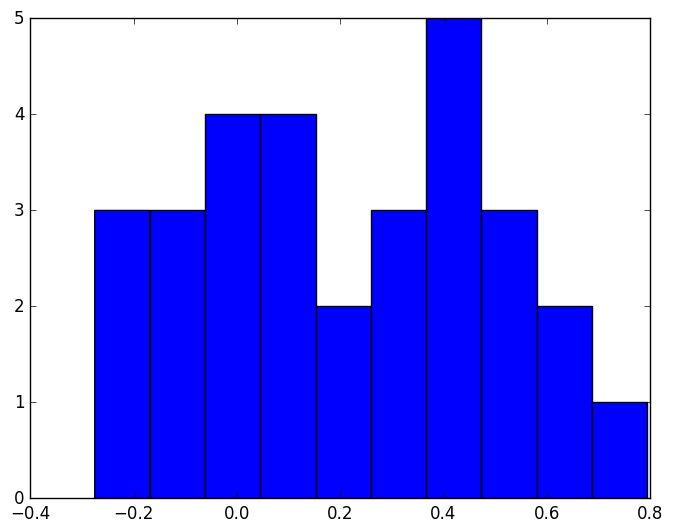

([3.0,3.0,4.0,4.0,2.0,3.0,5.0,3.0,2.0,1.0],[-0.275078,-0.16814,-0.0612011,0.0457373,0.152676,0.259614,0.366553,0.473491,0.580429,0.687368,0.794306],Any[PyObject <matplotlib.patches.Rectangle object at 0x33412f710>,PyObject <matplotlib.patches.Rectangle object at 0x33412fd90>,PyObject <matplotlib.patches.Rectangle object at 0x33413d450>,PyObject <matplotlib.patches.Rectangle object at 0x33413dad0>,PyObject <matplotlib.patches.Rectangle object at 0x33413dfd0>,PyObject <matplotlib.patches.Rectangle object at 0x334149810>,PyObject <matplotlib.patches.Rectangle object at 0x334149e90>,PyObject <matplotlib.patches.Rectangle object at 0x334156550>,PyObject <matplotlib.patches.Rectangle object at 0x334156bd0>,PyObject <matplotlib.patches.Rectangle object at 0x334163290>])

In [124]:
plt[:hist](w_ridge)

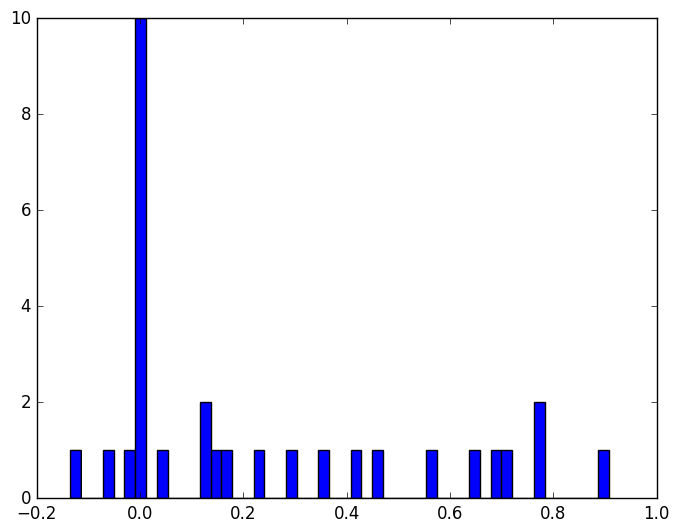

([1.0,0.0,0.0,1.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0],[-0.134716,-0.113863,-0.0930104,-0.0721579,-0.0513053,-0.0304527,-0.00960008,0.0112525,0.0321051,0.0529577,0.0738103,0.0946629,0.115515,0.136368,0.157221,0.178073,0.198926,0.219778,0.240631,0.261484,0.282336,0.303189,0.324041,0.344894,0.365747,0.386599,0.407452,0.428304,0.449157,0.47001,0.490862,0.511715,0.532567,0.55342,0.574272,0.595125,0.615978,0.63683,0.657683,0.678535,0.699388,0.720241,0.741093,0.761946,0.782798,0.803651,0.824504,0.845356,0.866209,0.887061,0.907914],Any[PyObject <matplotlib.patches.Rectangle object at 0x334376510>,PyObject <matplotlib.patches.Rectangle object at 0x334376b90>,PyObject <matplotlib.patches.Rectangle object at 0x334383250>,PyObject <matplotlib.patches.Rectangle object at 0x3343838d0>,PyObject <matplotlib.patches.Rectangle object at 0x334383f50>,PyObje

In [125]:
plt[:hist](w_lasso, bins=50)

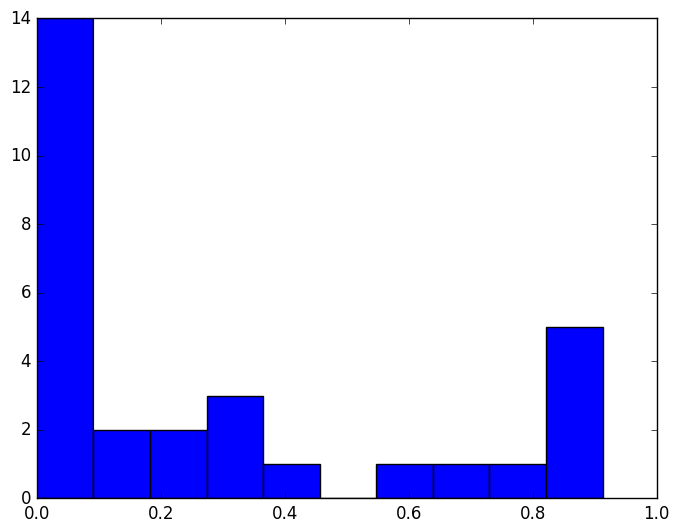

([14.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,5.0],[4.34602e-7,0.0912492,0.182498,0.273747,0.364995,0.456244,0.547493,0.638742,0.72999,0.821239,0.912488],Any[PyObject <matplotlib.patches.Rectangle object at 0x33469ced0>,PyObject <matplotlib.patches.Rectangle object at 0x3346a8590>,PyObject <matplotlib.patches.Rectangle object at 0x3346a8c10>,PyObject <matplotlib.patches.Rectangle object at 0x3346b72d0>,PyObject <matplotlib.patches.Rectangle object at 0x3346b7950>,PyObject <matplotlib.patches.Rectangle object at 0x3346b7fd0>,PyObject <matplotlib.patches.Rectangle object at 0x3346c4690>,PyObject <matplotlib.patches.Rectangle object at 0x3346c4d10>,PyObject <matplotlib.patches.Rectangle object at 0x3346d03d0>,PyObject <matplotlib.patches.Rectangle object at 0x3346d0a50>])

In [126]:
plt[:hist](w_nonneg)

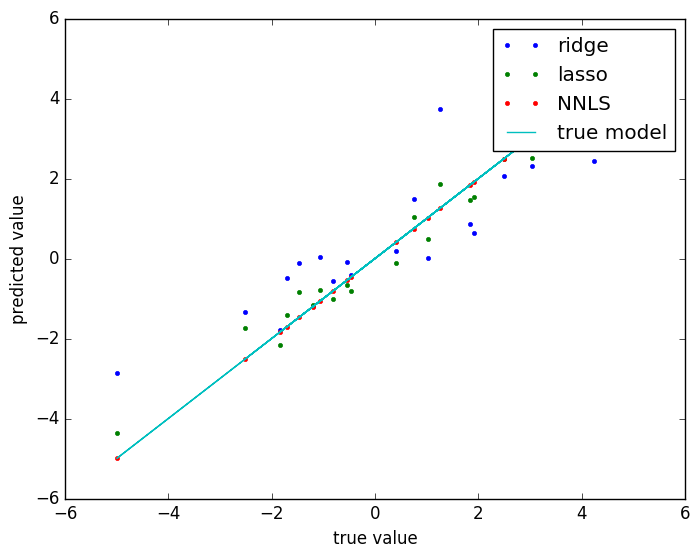

PyObject <matplotlib.text.Text object at 0x33472ab10>

In [127]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

plot(ytest,Xtest*w_ridge,label="ridge",".")
plot(ytest,Xtest*w_lasso,label="lasso",".")
plot(ytest,Xtest*w_nonneg,label="NNLS",".")
plot(ytest,ytest,label="true model")
legend()
xlabel("true value")
ylabel("predicted value")

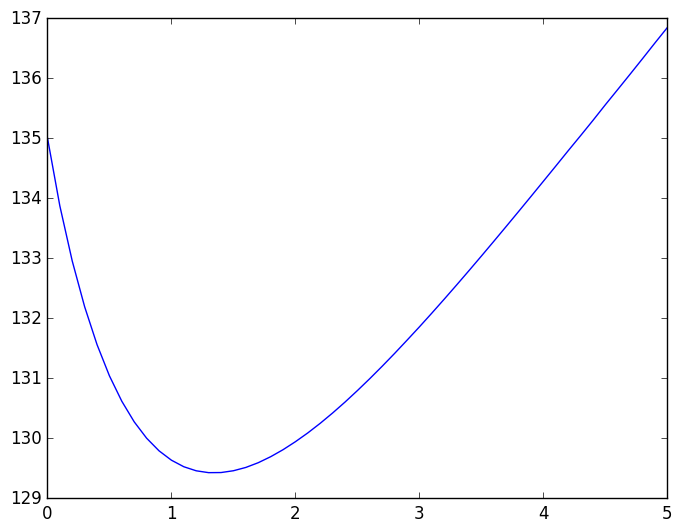

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x335eeae50>

In [144]:
# cross validate over lambda

w = .5*randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

error = Float64[]
λs = 0:.1:5
for λ in λs
    w = ridge_regression(X,y; λ=λ)
    push!(error, sum((ytest - Xtest*w).^2))
end
plot(λs, error)